In [1]:
# Import libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sqlalchemy import create_engine
import sqlite3

In [2]:
# Opens the JSON file containing watch history data and loads it into a DataFrame
with open("data/watch-history.json", encoding="utf-8") as f:
    watch_data = json.load(f)

df = pd.json_normalize(watch_data) # Normalize the JSON data into a flat table

print(df.columns)  # Print the columns of the DataFrame to understand its structure
# df.head() # Display the first few rows of the DataFrame for inspection

Index(['header', 'title', 'titleUrl', 'subtitles', 'time', 'products',
       'activityControls', 'details', 'description'],
      dtype='object')


In [3]:
# Modify the DataFrame to extract relevant information
df = df[df["header"] ==  "YouTube"] # Filter rows where header is "YouTube" (removes YouTube Music)
df = df[-df["title"].str.contains("Viewed")] # Exclude rows where title contains "Viewed" (removes interactions with YouTube posts)
df = df[df["subtitles"].notna()] # Filter out rows where subtitles are not available
df["title"] = df["title"].str.removeprefix("Watched ") # Remove "Watched " prefix from titles
df["time"] = pd.to_datetime(df["time"], format='ISO8601', utc=True) # Convert time to datetime with UTC timezone
df["time"] = df["time"].dt.tz_convert("Asia/Manila") # Convert time to Asia/Manila timezone
df["channel"] = df["subtitles"].apply(lambda x: x[0]['name']) # Extract channel name from subtitles

# Keep relevant columns
cleaned_df = df[['title', 'titleUrl', 'channel', 'time']]
# cleaned_df.head() # Display the first few rows of the cleaned DataFrame

In [4]:
# Display the top 10 YouTube channels based on the number of videos watched
top_channels = cleaned_df["channel"].value_counts().head(10) # Get the count of videos per channel and take the top 10
print("My Top 10 YouTube Channels:", top_channels)

My Top 10 YouTube Channels: channel
WWE             1509
CaseOh           814
GothamChess      740
MoreCaseOh       608
CVV CLIPS        584
PaoLUL           487
UpUpDownDown     316
camman18         268
PhiDX            235
PewDiePie        225
Name: count, dtype: int64


In [ ]:
# Visualizes my Top 10 YouTube channels using Plotly Express
fig = px.bar(
    top_channels.sort_values(ascending=True), # Sort the channels by number of videos watched
    x=top_channels.sort_values(ascending=True).values, # Get the counts of videos watched
    y=top_channels.sort_values(ascending=True).index, # Get the channel names
    labels={'x': 'Number of Videos Watched', 'y': 'YouTube Channel'}, # Set axis labels
    title='Top 10 YouTube Channels by Number of Videos Watched', # Set the title of the chart
    orientation='h' # Set orientation to horizontal
)

fig.show() # Show the plot

In [6]:
cleaned_df_copy = cleaned_df.copy() # Create a copy of the cleaned DataFrame to avoid modifying the original

In [7]:
# Count the number of videos watched per month and prepare for visualization
cleaned_df_copy["month"] = cleaned_df_copy["time"].dt.month # Extract the month from the time column
monthly_counts = cleaned_df_copy['month'].value_counts().sort_index() # Count the number of videos watched per month and sort by month
monthly_df = monthly_counts.reset_index() # Reset index to convert Series to DataFrame
monthly_df.head() # Display the first few rows of the monthly DataFrame

,month,count
0,1,4972
1,2,2552
2,3,3364
3,4,4005
4,5,3542


In [8]:
# Visualizes the watch activity by month using Plotly Express
fig = px.bar(
    monthly_df, # Use the monthly DataFrame for plotting
    x='month', # Use the month column for x-axis
    y='count', # Use the count of videos watched for y-axis
    title='Watch Activity by Month', # Set the title of the chart
    labels={'month': 'Month of Year', 'count': 'Number of Videos'}, # Set axis labels
    hover_data=['count'] # Show count in hover data
    )

fig.show() # Show the plot

In [9]:
# Count the number of videos watched per hour and prepare for visualization
cleaned_df_copy["hour"] = cleaned_df_copy["time"].dt.hour # Extract the hour from the time column
hourly_counts = cleaned_df_copy['hour'].value_counts().sort_index() # Count the number of videos watched per hour and sort by hour
hourly_df = hourly_counts.reset_index() # Reset index to convert Series to DataFrame
hourly_df.head() # Display the first few rows of the hourly DataFrame

,hour,count
0,0,658
1,1,39
2,2,3
3,3,48
4,4,714


In [10]:
# Visualizes the watch activity by hour using Plotly Express
fig = px.bar(
    hourly_df, # Use the hourly DataFrame for plotting
    x='hour', # Use the hour column for x-axis
    y='count', # Use the count of videos watched for y-axis
    title='Watch Activity by Hour', # Set the title of the chart
    labels={'hour': 'Hour of Day', 'count': 'Number of Videos'}, # Set axis labels
    hover_data=['count'] # Show count in hover data
    )

fig.show()

In [11]:
# Visualizes the watch history over time (monthly) using Plotly Express
cleaned_df_copy["year_month"] = cleaned_df_copy["time"].dt.to_period("M").astype(str) # Create a new column for year and month
monthly_counts = cleaned_df_copy["year_month"].value_counts().sort_index() # Count the number of videos watched per month and sort by month
monthly_df = monthly_counts.reset_index() # Reset index to convert Series to DataFrame
monthly_df.head() # Display the first few rows of the monthly DataFrame

C:\Users\Mark Wilson Mendoza\AppData\Local\Temp\ipykernel_18412\3422375033.py:2: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



,year_month,count
0,2022-12,348
1,2023-01,873
2,2023-02,355
3,2023-03,583
4,2023-04,485


In [12]:
# Prepare the DataFrame for plotting
fig = px.line(
    monthly_df[:-1], # Exclude the last month since it is incomplete
    x="year_month", # Use the year_month column for x-axis
    y="count", # Use the count of videos watched for y-axis
    title="Watch History Over Time (Monthly)", # Set the title of the chart
    labels={"year_month": "Date", "count": "Number of Videos"}, # Set axis labels
    hover_data=["count"], # Show count in hover data
    markers=True # Add markers to the line plot
    )

fig.show() # Show the plot

In [13]:
# Count the number of videos watched per week and prepare for visualization
cleaned_df_copy["week"] = cleaned_df_copy["time"].dt.to_period("W").apply(lambda x: x.start_time) # Create a new column for weeks in string format
weekly_counts = cleaned_df_copy["week"].value_counts().sort_index() # Count the number of videos watched per week and sort by week
weekly_df = weekly_counts.reset_index() # Reset index to convert Series to DataFrame
weekly_df.head() # Display the first few rows of the weekly DataFrame

C:\Users\Mark Wilson Mendoza\AppData\Local\Temp\ipykernel_18412\2292168050.py:2: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



,week,count
0,2022-12-19,223
1,2022-12-26,163
2,2023-01-02,177
3,2023-01-09,142
4,2023-01-16,245


In [14]:
# Visualizes the watch history over time (monthly) using Plotly Express
fig = px.line(
    weekly_df[:-1], # Exclude the last week since it may be incomplete
    x="week", # Use the week column for x-axis
    y="count", # Use the count of videos watched for y-axis
    title="Watch History Over Time (Weekly)", # Set the title of the chart
    labels={"week": "Date", "count": "Number of Videos"}, # Set axis labels
    hover_data=["count"], # Show count in hover data
    markers=True # Add markers to the line chart
    )

fig.show() # Show the plot

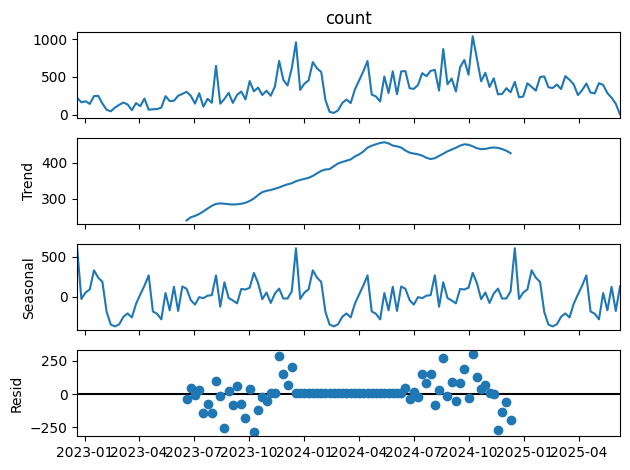

In [15]:
# Decompose the weekly counts to analyze trends and seasonality
decomposed = seasonal_decompose(weekly_counts) # Decompose the weekly counts into trend, seasonal, and residual components
decomposed.plot() # Plot the decomposed components
plt.show() # Show the plot

In [16]:
train_set = weekly_counts[:-11] # Use all but the last 10 weeks for training
test_set = weekly_counts[-10:-1] # Use the last 10 weeks for testing

ADF Statistic: -3.7951264672638505
p-value: 0.0029575730463442564


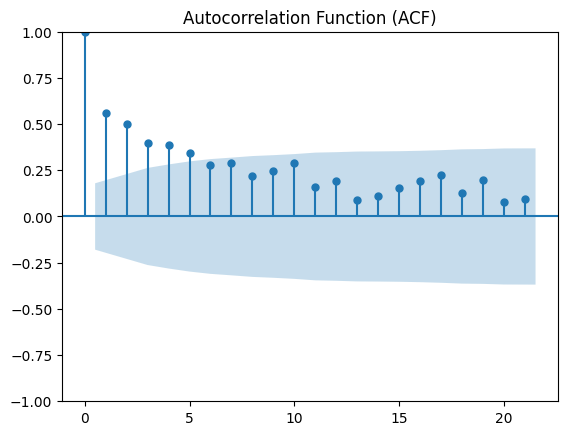

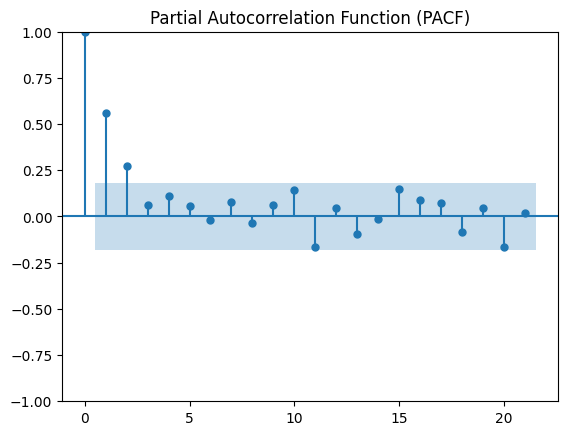

In [17]:
# Perform Augmented Dickey-Fuller test to check for stationarity
adf_result = adfuller(train_set) # Perform the ADF test on weekly
print("ADF Statistic:", adf_result[0]) # Print the ADF statistic
print("p-value:", adf_result[1]) # Print the p-value of the test

# Plot ACF and PACF to determine the order of ARIMA model
plot_acf(train_set) # Plot the autocorrelation function
plt.title("Autocorrelation Function (ACF)") # Set title for ACF plot
plt.show() # Show the ACF plot

plot_pacf(train_set) # Plot the partial autocorrelation function
plt.title("Partial Autocorrelation Function (PACF)") # Set title for PACF plot 
plt.show() # Show the PACF plot

c:\Personal Folder\Codes\Projects\YouTube Data Analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-MON will be used.

c:\Personal Folder\Codes\Projects\YouTube Data Analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-MON will be used.

c:\Personal Folder\Codes\Projects\YouTube Data Analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-MON will be used.

c:\Personal Folder\Codes\Projects\YouTube Data Analysis\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



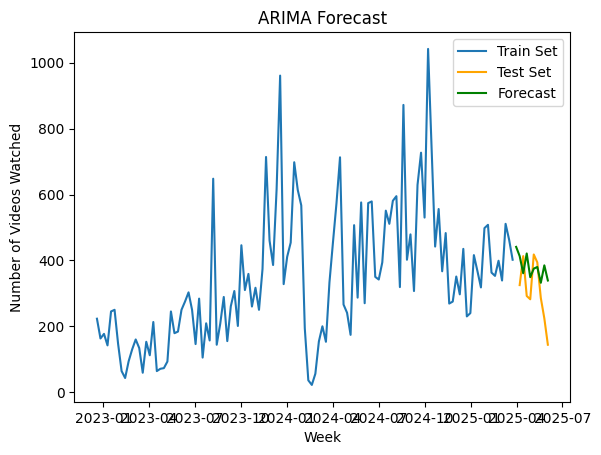

In [18]:
# Fit an ARIMA model to the training set
# The order (p, d, q) is set based on the ACF and PAC
model = ARIMA(train_set, order=(5, 0, 2))
model_fit = model.fit()

forecast = round(model_fit.forecast(steps=10))

plt.plot(train_set, label='Train Set') # Plot the training set
plt.plot(test_set, label='Test Set', color="orange") # Plot the test set
plt.plot(forecast, label='Forecast', color="green") # Plot the forecast
plt.title("ARIMA Forecast") # Set title for the plot
plt.xlabel("Week") # Set x-axis label
plt.ylabel("Number of Videos Watched") # Set y-axis label
plt.legend() # Show legend
plt.show() # Show the plot

In [19]:
engine = create_engine('sqlite:///data/watch_history.db') # Create a SQLite database engine
cleaned_df.to_sql('watch_history', con=engine, if_exists='replace', index=False) # Save the cleaned DataFrame to the database

43792

In [20]:
conn = sqlite3.connect('data/watch_history.db') # Connect to the SQLite database
cursor = conn.cursor() # Create a cursor object to execute SQL commands

cursor.execute('''
    SELECT * FROM watch_history LIMIT 10;
''') # Execute a SQL command to select all data from the watch_history table
rows = cursor.fetchall() # Fetch all rows from the executed command
# for row in rows: # Iterate through each row
#     print(row) # Print each row to the console

conn.close() # Close the database connection